In [18]:
# importing packages

import pickle
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import  classification_report_imbalanced 
from sklearn.pipeline import make_pipeline
from skmultilearn.problem_transform import BinaryRelevance,ClassifierChain,LabelPowerset

In [19]:
# Reading dataset 

df_working=pd.read_csv('mbti_preprocessed.csv')

# Create a binary column for each of the 4 axis types for later analysis
df_working['I-E'] = df_working['type'].map(lambda x: 'Introversion' if x[0] == 'I' else 'Extroversion')
df_working['N-S'] = df_working['type'].map(lambda x: 'Intuition' if x[1] == 'N' else 'Sensing')
df_working['T-F'] = df_working['type'].map(lambda x: 'Thinking' if x[2] == 'T' else 'Feeling')
df_working['J-P'] = df_working['type'].map(lambda x: 'Judging' if x[3] == 'J' else 'Perceiving')

df_working.head()

,Unnamed: 0,type,posts,I-E,N-S,T-F,J-P
0,0,INFJ,happening weed intj moderation stuff suicide s...,Introversion,Intuition,Feeling,Judging
1,1,ENTP,easy clip psychologist hell Jack Tik away plac...,Extroversion,Intuition,Thinking,Perceiving
2,2,INTP,ish safe offender elaborate shape hopefully st...,Introversion,Intuition,Thinking,Perceiving
3,3,INTJ,aggressive dat compare hell Type wow state enc...,Introversion,Intuition,Thinking,Judging
4,4,ENTJ,skit chase easy refute boss fuck mention debat...,Extroversion,Intuition,Thinking,Judging


In [20]:
le=LabelEncoder()
df_working['I-E']=le.fit_transform(df_working['I-E'].values)
df_working['N-S']=le.fit_transform(df_working['N-S'].values)
df_working['T-F']=le.fit_transform(df_working['T-F'].values)
df_working['J-P']=le.fit_transform(df_working['J-P'].values)
df_working.head()

,Unnamed: 0,type,posts,I-E,N-S,T-F,J-P
0,0,INFJ,happening weed intj moderation stuff suicide s...,1,0,0,0
1,1,ENTP,easy clip psychologist hell Jack Tik away plac...,0,0,1,1
2,2,INTP,ish safe offender elaborate shape hopefully st...,1,0,1,1
3,3,INTJ,aggressive dat compare hell Type wow state enc...,1,0,1,0
4,4,ENTJ,skit chase easy refute boss fuck mention debat...,0,0,1,0


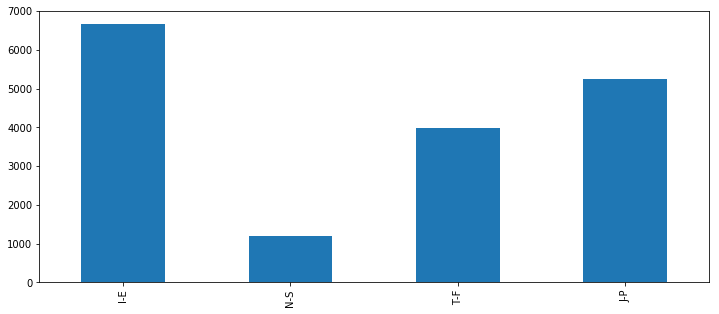

In [30]:
categories=df_working.columns
cat=[df_working[c].value_counts() for c in categories[3:]]
plt.figure(figsize=(12,5))
df_working.iloc[:,3:].sum(axis=0).plot.bar()

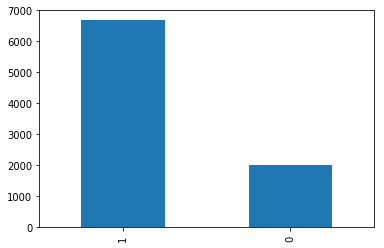

In [31]:
df_working['I-E'].value_counts().plot.bar()

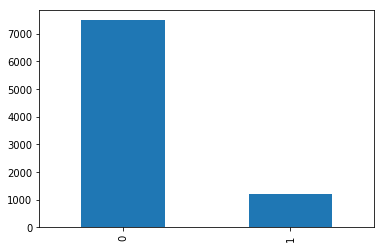

In [32]:
df_working['N-S'].value_counts().plot.bar()

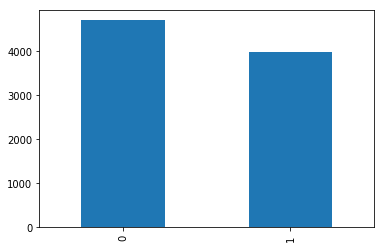

In [33]:
df_working['T-F'].value_counts().plot.bar()

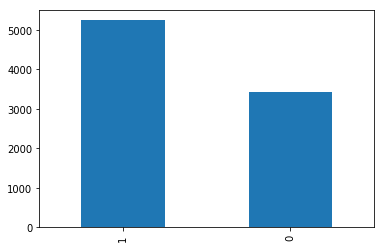

In [34]:
df_working['J-P'].value_counts().plot.bar()

In [8]:
# Add to the stopwords list each of the 16 codes
types = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp', \
         'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj']
stop = stopwords.words('english')

for type in types:
    stop.append(type)

stop_rev = stop    
# print(stop_rev)

# Cleaning text 
def cleaner(text):
    stemmer = PorterStemmer()                                        # replaces post separators with empty space
    text = re.sub(r'\bhttps?:\/\/.*?[\d\r\n\|\{\}\(\)\'\"\\/]*? ', 'URL ', text, flags=re.MULTILINE)  # replace hyperlink with 'URL'
    text = text.translate(str.maketrans('', '', string.punctuation)) # removes punctuation
    text = text.translate(str.maketrans('', '', string.digits))      # removes digits
    text = text.lower().strip()                                      # convert to lower case
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [87]:

X_train, X_test, y_train, y_test = train_test_split(df_working['posts'],
                                                   df_working.iloc[:,3:],
                                                   test_size=0.30, random_state=42)
X_train.shape,y_train.shape

((6072,), (6072, 4))

In [88]:
import gensim
from gensim.models import Doc2Vec

def doc2vec(X_train):
    document_tagged = []
    tagged_count = 0
    for line in X_train:
        document_tagged.append(gensim.models.doc2vec.TaggedDocument(line,[tagged_count]))
        tagged_count +=1 
    d2v = Doc2Vec(document_tagged)
    d2v.train(document_tagged,epochs=d2v.epochs,total_examples=d2v.corpus_count)
    return d2v.docvecs.vectors_docs

In [89]:
from sklearn.decomposition import PCA
def pca_fun(n_components, data):
    pca = PCA(n_components=n_components).fit(data)
    data = pca.transform(data)
    return data

In [90]:
# Let's explore the data representation of doc2vec for abstract column.
# Visualization the doc2vec representation
doc2vec = doc2vec(X_train) # takes string values
pca_data = pca_fun(5,doc2vec)

In [100]:
classifier=BinaryRelevance(RandomForestClassifier(min_samples_leaf=1, min_samples_split=6, n_estimators=120, 
                             criterion='gini', bootstrap='True', n_jobs= -1,random_state=20))
pipe = make_pipeline(TfidfVectorizer(stop_words='english',ngram_range=(1,2),norm='l2',max_features=500),classifier)

classifier.fit(pca_data, y_train)
# pipe.fit(X_train, y_train)
# y_pred = pipe.predict(X_test)
# probablity=pipe.predict_proba(X_test)
# Model Accuracy
# print("Random forest Accuracy:", accuracy_score(y_test, y_pred))

BinaryRelevance(classifier=RandomForestClassifier(bootstrap='True',
                                                  ccp_alpha=0.0,
                                                  class_weight=None,
                                                  criterion='gini',
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=6,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=120, n_jobs=-1,
  

In [101]:
def doc2vec(X_train):
    document_tagged = []
    tagged_count = 0
    for line in X_train:
        document_tagged.append(gensim.models.doc2vec.TaggedDocument(line,[tagged_count]))
        tagged_count +=1 
    d2v = Doc2Vec(document_tagged)
    d2v.train(document_tagged,epochs=d2v.epochs,total_examples=d2v.corpus_count)
    return d2v.docvecs.vectors_docs
doc2vec_test=doc2vec(X_test)
pca_data_test=pca_fun(5,doc2vec_test)
y_pred = classifier.predict(pca_data_test)

# Model Accuracy
print("Random forest Accuracy:", accuracy_score(y_test, y_pred))

Random forest Accuracy: 0.1790242028428736


In [102]:
pred_df=pd.DataFrame(y_pred.toarray(),columns=list(y_test.head(0)))
[print(key,'\n',classification_report_imbalanced(y_test[key],pred_df[key])) for key in list(y_test.head(0))]

I-E 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.22      0.02      0.98      0.04      0.14      0.02       572
          1       0.78      0.98      0.02      0.87      0.14      0.02      2031

avg / total       0.66      0.77      0.23      0.69      0.14      0.02      2603

N-S 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.86      1.00      0.00      0.92      0.00      0.00      2226
          1       0.00      0.00      1.00      0.00      0.00      0.00       377

avg / total       0.73      0.86      0.14      0.79      0.00      0.00      2603

T-F 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.52      0.59      0.36      0.56      0.46      0.22      1416
          1       0.43      0.36      0.59      0.39      0.46      0.21      1187

avg / total       0.48      0.49      0.47      0.48      0.4

/home/shiva/python_projects_directory/python_projects_env/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[None, None, None, None]

In [ ]:
# pickle_out = open("model_f.pickle","wb")
# pickle.dump(pipe, pickle_out)
# pickle_out.close()           
# pipe.fit(X_train, y_train)
# y_pred = pipe.predict(X_test)
#
# # Model Accuracy
# print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report_imbalanced(y_test, y_pred))
#
# pickle_out = open("model_f.pickle","wb")
# pickle.dump(pipe, pickle_out)
# pickle_out.close()							 
							 

In [99]:
for f,s in zip(y_test.values,pred_df.values):
    print(f,s)

[1 0 1 1] [1 0 0 0]
[1 0 1 0] [1 0 0 1]
[1 0 1 1] [1 0 1 0]
[0 0 0 1] [1 0 1 0]
[0 0 1 0] [1 0 0 1]
[1 0 0 0] [1 0 0 0]
[1 0 1 0] [1 0 1 1]
[0 0 1 1] [1 0 0 0]
[0 1 1 0] [0 0 1 1]
[1 0 1 1] [1 0 0 1]
[1 1 1 1] [1 0 1 1]
[0 0 0 1] [1 0 0 1]
[1 0 0 0] [1 0 0 1]
[0 0 0 1] [1 0 0 1]
[1 1 1 1] [0 0 1 1]
[1 0 0 0] [1 0 1 1]
[1 0 1 1] [1 0 0 1]
[1 0 1 1] [1 0 0 1]
[0 0 0 0] [1 0 1 0]
[1 0 0 0] [1 0 0 0]
[0 0 0 0] [1 0 1 0]
[1 1 1 1] [1 0 0 0]
[1 1 1 0] [1 0 1 1]
[1 0 0 0] [1 0 0 1]
[1 0 1 1] [1 0 0 0]
[1 0 0 0] [1 0 0 1]
[1 0 1 1] [0 0 1 1]
[1 0 0 1] [1 0 0 0]
[1 0 1 1] [1 0 0 0]
[1 1 1 1] [1 0 1 0]
[0 0 1 1] [1 0 1 0]
[1 0 1 0] [1 0 0 0]
[1 0 1 1] [1 0 0 0]
[1 1 1 1] [1 0 0 1]
[0 0 1 1] [1 0 0 1]
[1 1 0 1] [1 0 1 1]
[0 0 0 0] [1 0 0 0]
[1 0 0 0] [1 0 0 1]
[1 0 1 1] [1 0 0 1]
[1 0 0 0] [1 0 0 1]
[1 0 1 0] [1 0 0 1]
[0 0 0 1] [1 0 0 1]
[1 0 0 1] [1 0 1 1]
[1 0 0 1] [1 0 1 0]
[0 0 0 0] [1 0 1 1]
[1 0 1 1] [1 0 0 1]
[1 0 0 1] [1 0 1 1]
[1 0 1 1] [1 0 0 1]
[1 0 0 1] [1 0 0 1]
[1 0 0 1] [1 0 1 0]


[1 0 0 0] [1 0 1 1]
[1 1 1 0] [1 0 0 1]
[1 0 1 0] [1 0 0 1]
[1 1 1 1] [1 0 0 1]
[0 0 1 1] [1 0 1 0]
[1 0 0 1] [1 0 0 1]
[1 0 1 1] [1 0 0 1]
[1 1 0 1] [1 0 0 1]
[1 0 0 1] [1 0 1 1]
[1 0 0 0] [1 0 0 1]
[1 0 0 1] [1 0 0 1]
[1 0 1 1] [1 0 0 1]
[1 1 1 0] [1 0 0 1]
[1 0 1 1] [0 0 1 1]
[1 1 1 0] [1 0 0 1]
[1 1 1 1] [1 0 1 0]
[0 0 1 1] [1 0 0 0]
[1 0 0 1] [1 0 1 0]
[1 0 0 1] [1 0 0 1]
[1 0 0 1] [1 0 1 0]
[1 0 1 1] [1 0 0 1]
[1 0 1 0] [1 0 0 1]
[1 0 0 1] [1 0 0 1]
[1 0 0 1] [1 0 0 1]
[1 0 0 0] [1 0 0 1]
[1 0 0 1] [1 0 0 1]
[0 0 0 1] [1 0 1 1]
[1 0 0 0] [1 0 0 1]
[1 0 0 1] [1 0 1 0]
[1 0 0 1] [1 0 0 0]
[1 0 1 1] [1 0 0 1]
[0 0 1 1] [1 0 0 1]
[1 0 1 0] [1 0 0 0]
[0 0 1 1] [1 0 0 1]
[0 0 0 1] [1 0 0 0]
[1 0 1 0] [1 0 0 1]
[1 0 0 0] [1 0 0 1]
[1 0 1 1] [0 0 0 1]
[1 0 1 1] [1 0 0 1]
[0 0 0 1] [1 0 0 1]
[1 0 1 0] [1 0 1 1]
[0 0 0 1] [1 0 0 0]
[1 0 0 0] [1 0 1 1]
[1 0 1 0] [1 0 0 1]
[1 0 0 1] [1 0 0 0]
[1 0 1 0] [1 0 0 0]
[1 0 0 0] [0 0 1 1]
[1 0 0 0] [1 0 0 1]
[1 0 0 0] [1 0 0 0]
[1 0 1 1] [1 0 1 0]


[1 1 0 1] [1 0 1 1]
[1 0 0 1] [1 0 1 0]
[1 1 0 1] [0 0 0 1]
[1 0 0 0] [1 0 1 1]
[1 0 0 0] [1 0 0 0]
[1 0 0 0] [0 0 1 1]
[0 0 1 0] [1 0 0 1]
[1 1 0 0] [1 0 1 1]
[0 1 1 1] [1 0 0 1]
[1 0 1 1] [1 0 0 1]
[1 0 0 0] [1 0 0 1]
[1 0 0 1] [1 0 0 0]
[1 0 1 0] [1 0 1 1]
[1 1 1 0] [1 0 0 0]
[1 0 0 0] [1 0 0 0]
[0 0 1 0] [1 0 0 1]
[1 0 1 1] [1 0 0 1]
[0 0 1 1] [1 0 0 1]
[1 0 0 1] [1 0 0 1]
[1 1 0 0] [1 0 0 1]
[1 0 0 1] [1 0 1 1]
[1 1 1 1] [1 0 1 1]
[1 0 1 1] [1 0 1 1]
[1 0 0 1] [1 0 0 0]
[1 1 0 1] [1 0 0 1]
[0 0 1 0] [1 0 0 1]
[1 0 1 1] [0 0 1 1]
[1 0 1 1] [1 0 0 1]
[1 0 0 0] [1 0 1 0]
[0 0 1 1] [0 0 0 1]
[1 0 1 1] [1 0 0 0]
[1 0 1 1] [1 0 0 1]
[1 0 0 1] [1 0 0 1]
[0 0 0 0] [1 0 0 1]
[0 0 1 0] [1 0 0 1]
[1 0 1 0] [1 0 0 1]
[0 0 0 1] [1 0 0 0]
[1 0 0 1] [1 0 0 0]
[0 0 0 1] [1 0 0 1]
[1 0 0 0] [1 0 0 1]
[0 1 1 0] [1 0 0 1]
[0 0 1 0] [1 0 0 1]
[1 0 0 1] [1 0 0 1]
[0 0 0 1] [1 0 1 0]
[1 0 1 1] [1 0 0 0]
[0 0 0 1] [1 0 0 0]
[1 0 1 0] [1 0 0 1]
[1 0 0 0] [1 0 1 1]
[1 0 0 0] [1 0 0 1]
[1 0 0 1] [1 0 0 0]


[1 1 0 0] [1 0 0 0]
[1 0 1 0] [1 0 0 0]
[1 0 1 1] [1 0 0 1]
[1 0 1 1] [1 0 0 1]
[1 0 0 0] [1 0 1 0]
[0 0 0 1] [1 0 0 0]
[1 0 0 0] [1 0 0 0]
[0 0 1 0] [1 0 0 1]
[1 0 0 1] [1 0 0 1]
[0 0 0 1] [1 0 0 1]
[0 0 1 1] [1 0 0 1]
[0 0 0 1] [1 0 1 0]
[1 0 1 0] [1 0 1 1]
[1 0 1 0] [1 0 1 1]
[0 1 1 1] [1 0 0 1]
[1 0 0 0] [1 0 0 1]
[1 0 0 1] [1 0 1 1]
[1 0 0 1] [1 0 0 1]
[1 0 0 1] [0 0 1 1]
[0 1 1 0] [1 0 1 1]
[1 0 1 1] [1 0 1 1]
[1 0 0 0] [1 0 0 0]
[0 0 1 0] [1 0 0 0]
[1 0 0 0] [1 0 0 0]
[1 1 1 1] [1 0 0 0]
[0 0 1 1] [1 0 0 1]
[1 0 0 0] [1 0 1 0]
[1 0 1 1] [1 0 0 0]
[1 0 0 1] [1 0 0 0]
[1 0 0 0] [1 0 0 0]
[0 0 1 0] [1 0 0 1]
[1 0 1 0] [1 0 0 0]
[1 0 1 1] [1 0 0 0]
[1 0 0 1] [1 0 0 0]
[1 0 0 1] [1 0 1 1]
[1 0 0 0] [1 0 0 1]
[0 0 1 1] [1 0 0 1]
[1 0 1 1] [1 0 0 0]
[1 1 1 0] [1 0 0 1]
[1 0 1 1] [1 0 0 0]
[1 0 1 1] [1 0 0 0]
[1 0 1 0] [1 0 0 1]
[1 0 0 1] [1 1 1 1]
[0 0 0 1] [1 0 0 1]
[1 0 0 1] [1 0 0 0]
[1 0 0 0] [1 0 0 1]
[1 0 1 0] [1 0 0 1]
[0 0 0 1] [1 0 0 0]
[1 0 0 0] [1 0 0 1]
[0 0 0 1] [1 0 0 1]
